# Null Distribution Testing: Statistical Validation

**Project:** Concept-Driven Disentanglement for Interpretable SC-FC Coupling

**Paper Reference:** *A Concept-Driven Disentanglement Framework for Interpretable Graph Neural Networks in Structure-Function Coupling*

## Overview
A key question remains: **Are the SHAP contribution ratios we observed in the previous notebook statistically significant?**

To answer this, we employ a **Null Model Testing** approach.
1.  **Hypothesis:** If the structural concepts (e.g., Normal vs. Outlier) carry no specific information, training the model on **randomly generated masks** (with the same edge count ratio) should yield a distribution of SHAP ratios centered around a baseline (e.g., 1.0 or the data split ratio).
2.  **Method:** We repeatedly train the Ensemble GNN on random masks ($N=100$ permutations in the paper, $N=20$ for this demo) and calculate the SHAP ratio for each run.
3.  **Validation:** We compare the SHAP ratio from our *actual* experiment (Normal vs. Outlier) against this generated Null Distribution.

In [1]:
import os
import torch

# 1. Force install PyTorch 2.8.0 with CUDA 12.6
# We use --upgrade --force-reinstall to overwrite whatever Colab loaded by default
!pip install torch==2.8.0+cu126 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 --upgrade

# 2. Verify the version before proceeding
import torch
print(f"Successfully installed PyTorch version: {torch.__version__}")

# 3. Set environment variable for PyG (PyTorch Geometric) installation
# This tells pip explicitly which binary wheels to grab
os.environ['TORCH'] = "2.8.0+cu126"

Looking in indexes: https://download.pytorch.org/whl/cu126
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.24.1%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.9.1%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.24.0%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.9.0%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)


In [2]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric-temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 6.5 MB/s eta 0:00:00


In [3]:
import torch
from torch_geometric.data import Data

def create_graph_from_sc(sc_matrix, fc_matrix, edge_length_matrix):
    """
    Creates a graph object from SC, FC, and edge length matrices.
    """
    num_nodes = sc_matrix.shape[0]

    # Node features: one-hot encodings
    x = torch.eye(num_nodes)

    edge_index = []
    edge_attr = []
    y = []
    edge_lengths = [] # New list to store edge lengths

    for i in range(num_nodes):
        for j in range(num_nodes):
            edge_index.append([i, j])
            edge_attr.append(sc_matrix[i, j])
            y.append(fc_matrix[i, j])
            edge_lengths.append(edge_length_matrix[i, j]) # Store the corresponding edge length


    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    edge_lengths = torch.tensor(edge_lengths, dtype=torch.float) # Convert to a tensor

    # Add edge_lengths as an attribute to the Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, edge_length=edge_lengths)
    return data

from torch_geometric.data import InMemoryDataset

class SCGraphDataset(InMemoryDataset):
    """
    A dataset of graphs, where each graph is created from SC, FC, and edge length data.
    """
    def __init__(self, dataset, transform=None):
        super().__init__('.', transform)
        # Now we pass 'sc', 'fc', and 'edge_length' to the graph creation function
        self.data_list = [
            create_graph_from_sc(item['sc'], item['fc'], item['edge_length']) for item in dataset
        ]

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

In [4]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch_scatter

class SingleGNN(nn.Module):
    """
    A single GNN module that processes graph data and outputs node embeddings.
    Unchanged from your original code.
    """
    def __init__(self, feature_num, hidden_conv_dims, output_embedding_dim, GNN_impl=GCNConv):
        super(SingleGNN, self).__init__()
        self.convs = nn.ModuleList()
        self.relus = nn.ModuleList()

        current_dim = feature_num
        for hidden_dim in hidden_conv_dims:
            self.convs.append(GNN_impl(current_dim, hidden_dim))
            self.relus.append(nn.ReLU())
            current_dim = hidden_dim

        self.convs.append(GNN_impl(current_dim, output_embedding_dim))
        self.relus.append(nn.ReLU())

    def forward(self, x, edge_index, edge_weight):
        for conv, relu in zip(self.convs, self.relus):
            x = relu(conv(x, edge_index, edge_weight))
        return x

class EnsembleGNNNet(nn.Module):
    """
    An ensemble of two GNNs for short and long-distance connections.
    """
    def __init__(self, feature_num=116,
                 gnn_intermediate_dims=[256],
                 gnn_output_embedding_dim=8,
                 dnn_hidden_dim=64,
                 GNN_impl=GCNConv):
        super(EnsembleGNNNet, self).__init__()

        self.gnn_short = SingleGNN(feature_num, gnn_intermediate_dims, gnn_output_embedding_dim, GNN_impl=GNN_impl)
        self.gnn_long = SingleGNN(feature_num, gnn_intermediate_dims, gnn_output_embedding_dim, GNN_impl=GNN_impl)

        mlp_input_dim = (gnn_output_embedding_dim * 2) * 2
        self.dnn = nn.Sequential(
            nn.Linear(mlp_input_dim, dnn_hidden_dim),
            nn.ReLU(),
            nn.Linear(dnn_hidden_dim, 1)
        )

    def forward(self, x, edge_index, edge_weight, edge_length, label_edge_index):
        """
        Forward pass for the EnsembleGNNNet.
        Now takes 'edge_length' as an argument.
        """
        # --- Preprocess edge_weight based on edge_length ---
        is_actual_edge = (edge_weight > 0).float()

        # GNN for short-distance connections
        edge_weight_first = torch.where(
            (edge_length == 1) & (is_actual_edge.bool()),
            edge_weight,
            torch.zeros_like(edge_weight)
        )

        # GNN for long-distance connections
        edge_weight_second = torch.where(
            (edge_length == 0) & (is_actual_edge.bool()),
            edge_weight,
            torch.zeros_like(edge_weight)
        )

        # --- Get node embeddings from each GNN ---
        x_embed_gnn_first = self.gnn_short(x, edge_index, edge_weight_first)
        x_embed_gnn_second = self.gnn_long(x, edge_index, edge_weight_second)

        x_combined_node_embeddings = torch.cat((x_embed_gnn_first, x_embed_gnn_second), dim=-1)

        # --- Prepare input for the final MLP ---
        source_nodes_combined_emb = x_combined_node_embeddings[label_edge_index[0]]
        target_nodes_combined_emb = x_combined_node_embeddings[label_edge_index[1]]

        mlp_input = torch.cat((source_nodes_combined_emb, target_nodes_combined_emb), dim=-1)

        out = self.dnn(mlp_input)
        return out, mlp_input

## 1. Helper Functions
We define the necessary functions to generate random masks and calculate Pearson correlations.
* `create_random_masks_for_subject`: Randomly assigns edges to "Concept 1" or "Concept 2" based on a target ratio (e.g., 95% vs 5%).

In [5]:
def create_random_masks_for_subject(matrix_shape, ratio_ones):
    """
    Creates two complementary random binary masks for a single subject.

    Args:
        matrix_shape (tuple): The shape of the matrix (e.g., (116, 116)).
        ratio_ones (float): The proportion of elements that should be 1 in the first mask.

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing mask1 and its inverse, mask2.
    """
    num_elements = matrix_shape[0] * matrix_shape[1]
    num_ones = int(num_elements * ratio_ones)
    num_zeros = num_elements - num_ones

    # Create a flat array with the desired number of ones and zeros
    flat_array = np.array([1] * num_ones + [0] * num_zeros)

    # Shuffle the array to randomize the positions of ones and zeros
    np.random.shuffle(flat_array)

    # Reshape back to the original matrix shape
    mask1 = flat_array.reshape(matrix_shape)

    return mask1

def set_diagonal_inplace(pred, value=1.0):
    num_nodes = int(pred.size(0) ** 0.5)
    if pred.dim() == 1:  # flattened vector
        pred_matrix = pred.view(num_nodes, num_nodes)
        idx = torch.arange(num_nodes)
        pred_matrix[idx, idx] = value
    else:
        raise ValueError("Expected a 1D flattened FC vector.")

def calculate_pearson(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    r, _ = pearsonr(y_true, y_pred)
    return r

## 2. Null Distribution Generation Loop
**Warning: Computational Intensity**
This cell runs multiple full training loops (20 experiments x 100 epochs).
* **For Demonstration:** We run 20 permutations to generate a small histogram.
* **For Paper Replication:** The manuscript results (100 permutations) are provided in `.csv` format to save time.

**Procedure per Iteration:**
1.  Generate random masks with a fixed split (e.g., 95% Concept 1 / 5% Concept 2).
2.  Train the Ensemble GNN from scratch.
3.  Calculate the SHAP contribution ratio (Concept 2 / Concept 1).
4.  Log the result.

 **Note:** The reason we use 95/5 ratio is because the concept we investigate for this demo (outlier vs normal) produce this data split

In [6]:
import copy
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import numpy as np
from scipy.stats import pearsonr
import shap
from tqdm.notebook import tqdm
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

fc = np.load('MICA_FC_data_100p.npy')
sc = np.load('MICA_SC_data_100p.npy')

# Normalize the sc and fc data
eps = 1e-8
SC_min = sc.min(axis=(1, 2), keepdims=True)  # Minimum value for each matrix
SC_max = sc.max(axis=(1, 2), keepdims=True)  # Maximum value for each matrix
sc = (sc - SC_min) / (SC_max - SC_min + eps)


FC_min = fc.min(axis=(1, 2), keepdims=True)  # Minimum value for each matrix
FC_max = fc.max(axis=(1, 2), keepdims=True)  # Maximum value for each matrix
fc = (fc - FC_min) / (FC_max - FC_min + eps)

# Create a blank master dataframe with features: Experiment#, GroupR, IndividualR, Concept1, Concept2, ConceptRatio
df = pd.DataFrame(columns=['Experiment#', 'GroupR', 'IndividualR', 'Concept1', 'Concept2', 'ConceptRatio'])

for experiment_number in range(20):

    # Define the ratio for the random split (e.g., 0.5 for 50/50)
    CONCEPT_RATIO = 0.95
    print(f"Setting up experiment with a {CONCEPT_RATIO*100}/{(1-CONCEPT_RATIO)*100} random split.")

    length = []
    for i in range(50):
        length.append(create_random_masks_for_subject(matrix_shape=(116, 116), ratio_ones=CONCEPT_RATIO))

    dataset = []
    for i in range(50):
        sc_subject = sc[i]
        fc_subject = fc[i]
        dataset.append({
            "subject_id": i,
            "sc": sc_subject,
            "fc": fc_subject,
            "edge_length": length[i]
        })

    print("-- Successfully created dataset... Continuing to training --")


    # Set seed
    torch.random.manual_seed(42)

    # Convert to Graph
    graph_dataset = SCGraphDataset(dataset)

    # Split full dataset
    train_size = int(0.7 * len(graph_dataset))
    test_size = len(graph_dataset) - train_size
    train_dataset, test_dataset = random_split(graph_dataset, [train_size, test_size])

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

    model = EnsembleGNNNet(
        feature_num=116,
        gnn_intermediate_dims=[32],
        gnn_output_embedding_dim=32,
        dnn_hidden_dim=128
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # loss_fn = nn.MSELoss(reduction='mean')
    loss_fn = nn.L1Loss(reduction='none')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=5
    )

    # Training
    epochs = 100
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    best_model_state = None

    # Wrap the range of epochs with tqdm for a master progress bar
    epoch_bar = tqdm(range(epochs), desc="Starting Training")

    for epoch in epoch_bar:
        # --- Training Phase ---
        model.train()
        total_train_loss = 0
        # Optional: For even more detail, you can wrap the loader itself
        # for data in tqdm(train_loader, desc="Training", leave=False):
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            y_pred = model(data.x, data.edge_index, data.edge_attr, data.edge_length, data.edge_index)[0].squeeze()
            # loss = loss_fn(y_pred, data.y)

            # --- WEIGHTED LOSS CALCULATION ---
            unweighted_loss = loss_fn(y_pred, data.y)

            # 1. Dynamically count edges per concept in the current batch
            num_concept1 = torch.sum(data.edge_length == 1).float()
            num_edges = len(data.edge_length)
            num_concept2 = num_edges - num_concept1

            # 2. Calculate inverse frequency weights
            epsilon = 1e-6
            weight1 = num_edges / (2.0 * (num_concept1 + epsilon))
            weight2 = num_edges / (2.0 * (num_concept2 + epsilon))

            # 3. Assign weights to each edge's loss
            loss_weights = torch.ones_like(unweighted_loss)
            loss_weights[data.edge_length == 1] = weight1
            loss_weights[data.edge_length == 0] = weight2

            # 4. Calculate the final, weighted loss
            loss = (unweighted_loss * loss_weights).mean()
            # --- END OF MODIFICATION ---

            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- Validation Phase ---
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                y_pred = model(data.x, data.edge_index, data.edge_attr, data.edge_length, data.edge_index)[0].squeeze()
                # loss = loss_fn(y_pred, data.y)

                # --- WEIGHTED LOSS CALCULATION ---
                unweighted_loss = loss_fn(y_pred, data.y)

                # 1. Dynamically count edges per concept in the current batch
                num_concept1 = torch.sum(data.edge_length == 1).float()
                num_edges = len(data.edge_length)
                num_concept2 = num_edges - num_concept1

                # 2. Calculate inverse frequency weights
                epsilon = 1e-6
                weight1 = num_edges / (2.0 * (num_concept1 + epsilon))
                weight2 = num_edges / (2.0 * (num_concept2 + epsilon))

                # 3. Assign weights to each edge's loss
                loss_weights = torch.ones_like(unweighted_loss)
                loss_weights[data.edge_length == 1] = weight1
                loss_weights[data.edge_length == 0] = weight2

                # 4. Calculate the final, weighted loss
                loss = (unweighted_loss * loss_weights).mean()
                # --- END OF MODIFICATION ---

                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        # Update the scheduler with the validation loss
        scheduler.step(avg_test_loss)

        # Save the best model state based on validation loss
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_model_state = copy.deepcopy(model.state_dict())
            # The print statement is replaced by the tqdm description,
            # but you could add a visual cue like a star to the bar.
            # epoch_bar.set_description(f"⭐️ Epoch {epoch+1} ...")

        # Update the tqdm progress bar's description with the latest metrics
        epoch_bar.set_description(
            f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
            f"Test Loss: {avg_test_loss:.4f} | Best: {best_test_loss:.4f}"
        )

    # Restore best model
    model.load_state_dict(best_model_state)

    print("-- Successfully train a model... Continuing to evaluation --")

    model.eval()

    # Calculate group-avg pearson r
    total_pearson = 0
    iter = 0

    sum_preds = None
    sum_trues = None


    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            pred = model(data.x, data.edge_index, data.edge_attr, data.edge_length, data.edge_index)[0].squeeze()
            # make the diagonal 1 to avoid accounting it in pearson r
            set_diagonal_inplace(pred)
            true = data.y

            # Initialize accumulators with the shape of the first matrix
            if sum_preds is None:
                sum_preds = torch.zeros_like(pred.cpu())
                sum_trues = torch.zeros_like(true.cpu())

            sum_preds += pred.cpu()
            sum_trues += true.cpu()

            total_pearson += calculate_pearson(true, pred)
            iter += 1

    # Compute element-wise averages (still 2x2)
    avg_pred = sum_preds / iter
    avg_true = sum_trues / iter

    # Flatten both matrices to vectors
    avg_pred_flat = avg_pred.flatten()
    avg_true_flat = avg_true.flatten()

    group_pearson = calculate_pearson(avg_true_flat, avg_pred_flat)

    print("================================")
    print(f"🎯 Group-Level Pearson r: {group_pearson}")
    print("================================")

    print("================================")
    print(f"🎯 AVG. Individual Pearson r: {total_pearson / iter}")
    print("================================")

    print("-- Analyzing Feature... --")

    # --- Forward pass to get MLP input and output ---
    subject_id = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            fc_predictions, mlp_inputs_for_shap = model(data.x, data.edge_index, data.edge_attr, data.edge_length, data.edge_index)
            if subject_id<10:
                subject_id += 1
            else:
                break

    # print(f"Shape of FC predictions: {fc_predictions.shape}") # Should be [num_label_edges, 1]
    # print(f"Shape of MLP inputs for SHAP: {mlp_inputs_for_shap.shape}") # Should be [num_label_edges, 32]

    # --- SHAP Analysis ---

    # 1. Create a background dataset for DeepExplainer
    # It's good practice to use a subset of your training data's MLP inputs as background.
    # For this demo, we'll just use a few samples from our generated mlp_inputs_for_shap.
    # In a real scenario, this would come from your actual training data.
    background_data = mlp_inputs_for_shap[:50].clone().detach().requires_grad_(True)

    # 2. Initialize DeepExplainer
    # The model to explain is `model.dnn` (the MLP part)
    explainer = shap.DeepExplainer(model.dnn, background_data)

    # 3. Compute SHAP values for the MLP inputs
    # Ensure mlp_inputs_for_shap is a torch.Tensor with requires_grad=True
    mlp_inputs_to_explain = mlp_inputs_for_shap.clone().detach().requires_grad_(True)
    shap_values_mlp = explainer.shap_values(mlp_inputs_to_explain)

    # Calculate the absolute SHAP values
    abs_shap_values = np.abs(shap_values_mlp)

    # Ensure shap_values_mlp is a numpy array for easier processing
    if isinstance(shap_values_mlp, list):
        # DeepExplainer can return a list for multi-output models,
        # but our MLP has a single output (shape [num_label_edges, 1]),
        # so the list will contain one array of shape [num_label_edges, 32].
        shap_values_mlp = np.array(shap_values_mlp[0])
    elif not isinstance(shap_values_mlp, np.ndarray):
        shap_values_mlp = shap_values_mlp.detach().cpu().numpy()

    # Calculate the average of the absolute SHAP values along the first axis (samples)
    # This gives us an average importance score for each of the 32 features
    average_abs_shap_per_feature = np.mean(abs_shap_values, axis=0)

    # print("\nAverage Absolute SHAP Value for each of the 32 MLP input dimensions:")
    # print(average_abs_shap_per_feature)

    average_abs_shap_values = average_abs_shap_per_feature.flatten()

    # Define the output embedding dimension for each GNN
    gnn_output_embedding_dim = 32

    # Calculate the sum of mean absolute SHAP values for each category
    # The order of features in `average_abs_shap_values` is:
    # [Src_GNN1_Emb_0...7, Src_GNN2_Emb_0...7, Tgt_GNN1_Emb_0...7, Tgt_GNN2_Emb_0...7]

    # Source GNN1 (Weak Connections)
    src_gnn1_importance = np.sum(average_abs_shap_values[0 : gnn_output_embedding_dim])

    # Source GNN2 (Strong Connections)
    src_gnn2_importance = np.sum(average_abs_shap_values[gnn_output_embedding_dim : 2 * gnn_output_embedding_dim])

    # Target GNN1 (Weak Connections)
    tgt_gnn1_importance = np.sum(average_abs_shap_values[2 * gnn_output_embedding_dim : 3 * gnn_output_embedding_dim])

    # Target GNN2 (Strong Connections)
    tgt_gnn2_importance = np.sum(average_abs_shap_values[3 * gnn_output_embedding_dim : 4 * gnn_output_embedding_dim])

    # Total Short Connections
    total_short_connections = src_gnn1_importance + tgt_gnn1_importance

    # Total Long Connections
    total_long_connections = src_gnn2_importance + tgt_gnn2_importance

    # Ratio
    concept_ratio = total_long_connections / total_short_connections

    print(f"Concept 1: {total_short_connections}")
    print(f"Concept 2: {total_long_connections}")
    print(f"Concept Ratio: {concept_ratio}")

    ExperimentNumber = experiment_number + 1
    GroupR = group_pearson
    IndividualR = total_pearson / iter
    Concept1 = total_short_connections
    Concept2 = total_long_connections
    ConceptRatio = concept_ratio
    # Create a new DataFrame for the row you want to add
    new_row = pd.DataFrame([{'Experiment#': ExperimentNumber, 'GroupR': GroupR, 'IndividualR': IndividualR, 'Concept1': Concept1, 'Concept2': Concept2, 'ConceptRatio': ConceptRatio}])

    # Concatenate the original DataFrame with the new row
    df = pd.concat([df, new_row], ignore_index=True)

    # save df
    df.to_csv('results.csv', index=False)

Using device: cuda
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8894626498222351
🎯 AVG. Individual Pearson r: 0.7553495168685913
-- Analyzing Feature... --
Concept 1: 0.10178788757272082
Concept 2: 0.016260312362492885
Concept Ratio: 0.1597470263922704
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


/tmp/ipython-input-2179865400.py:335: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.9202856421470642
🎯 AVG. Individual Pearson r: 0.7779463529586792
-- Analyzing Feature... --
Concept 1: 0.15162352053295214
Concept 2: 0.02469728172980333
Concept Ratio: 0.1628855578804207
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8622849583625793
🎯 AVG. Individual Pearson r: 0.7269260883331299
-- Analyzing Feature... --
Concept 1: 0.06389683045810436
Concept 2: 0.012891738099977582
Concept Ratio: 0.2017586476128951
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8697779774665833
🎯 AVG. Individual Pearson r: 0.73883455991745
-- Analyzing Feature... --
Concept 1: 0.10083555833894828
Concept 2: 0.014303083358020245
Concept Ratio: 0.14184563058541227
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8931451439857483
🎯 AVG. Individual Pearson r: 0.7361592650413513
-- Analyzing Feature... --
Concept 1: 0.09116926832765405
Concept 2: 0.03760182504302808
Concept Ratio: 0.41243969303220185
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8854455351829529
🎯 AVG. Individual Pearson r: 0.7344800233840942
-- Analyzing Feature... --
Concept 1: 0.08568207358917607
Concept 2: 0.060312951171663465
Concept Ratio: 0.7039156342182946
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8751927018165588
🎯 AVG. Individual Pearson r: 0.7286547422409058
-- Analyzing Feature... --
Concept 1: 0.07927357626563358
Concept 2: 0.03986779510615914
Concept Ratio: 0.5029140475833749
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8699642419815063
🎯 AVG. Individual Pearson r: 0.7326582074165344
-- Analyzing Feature... --
Concept 1: 0.09213539962111394
Concept 2: 0.014372301749421392
Concept Ratio: 0.15599109363528288
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8761934638023376
🎯 AVG. Individual Pearson r: 0.7468241453170776
-- Analyzing Feature... --
Concept 1: 0.09886618919380978
Concept 2: 0.023619887500697604
Concept Ratio: 0.23890763559617906
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.9069583415985107
🎯 AVG. Individual Pearson r: 0.7512413263320923
-- Analyzing Feature... --
Concept 1: 0.17876171795320805
Concept 2: 0.03905221803554227
Concept Ratio: 0.2184596259349243
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.9222156405448914
🎯 AVG. Individual Pearson r: 0.7718107104301453
-- Analyzing Feature... --
Concept 1: 0.14879754105113738
Concept 2: 0.05814956417454478
Concept Ratio: 0.3907965398068001
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8649773001670837
🎯 AVG. Individual Pearson r: 0.7325953245162964
-- Analyzing Feature... --
Concept 1: 0.06148805018002277
Concept 2: 0.029472236547546635
Concept Ratio: 0.47931649257471576
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8049943447113037
🎯 AVG. Individual Pearson r: 0.6747549772262573
-- Analyzing Feature... --
Concept 1: 0.055685704680330905
Concept 2: 0.059340715233121503
Concept Ratio: 1.0656364245325176
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.9084042906761169
🎯 AVG. Individual Pearson r: 0.7561089396476746
-- Analyzing Feature... --
Concept 1: 0.18640169134499834
Concept 2: 0.04309228528440934
Concept Ratio: 0.23117969034225513
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8797476887702942
🎯 AVG. Individual Pearson r: 0.7367275953292847
-- Analyzing Feature... --
Concept 1: 0.1273100758495281
Concept 2: 0.04601592673698413
Concept Ratio: 0.36144764214398745
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.9216068387031555
🎯 AVG. Individual Pearson r: 0.7685937285423279
-- Analyzing Feature... --
Concept 1: 0.1501613792188617
Concept 2: 0.03402243024536268
Concept Ratio: 0.22657244107870542
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8824223875999451
🎯 AVG. Individual Pearson r: 0.7351707220077515
-- Analyzing Feature... --
Concept 1: 0.08020012289841877
Concept 2: 0.05153867422242577
Concept Ratio: 0.6426258758693487
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.9276861548423767
🎯 AVG. Individual Pearson r: 0.7713181376457214
-- Analyzing Feature... --
Concept 1: 0.14882493408535602
Concept 2: 0.044409836612668854
Concept Ratio: 0.29840320028093104
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.8908990025520325
🎯 AVG. Individual Pearson r: 0.7531902194023132
-- Analyzing Feature... --
Concept 1: 0.11093175827741272
Concept 2: 0.034014838110916504
Concept Ratio: 0.30662849520381585
Setting up experiment with a 95.0/5.000000000000004 random split.
-- Successfully created dataset... Continuing to training --


Starting Training:   0%|          | 0/100 [00:00<?, ?it/s]

-- Successfully train a model... Continuing to evaluation --
🎯 Group-Level Pearson r: 0.9158741235733032
🎯 AVG. Individual Pearson r: 0.7656488418579102
-- Analyzing Feature... --
Concept 1: 0.10136655027159824
Concept 2: 0.02316997236114139
Concept Ratio: 0.22857611607636366


## 3. Visualization: Real vs. Null Distribution
We load the full experimental results (from the CSV provided in the repo) and plot the Null Distribution.

**Interpretation:**
* **Blue Histogram:** The distribution of SHAP ratios expected by random chance (the Null Hypothesis).
* **Black Line:** The actual SHAP ratio observed in our "Normal vs. Outlier" experiment (approx 0.97).
* **Conclusion:** If the Black Line falls outside the standard deviation (Green Dotted Lines) or is distinct from the mean, it indicates the specific structural configuration (Outliers) has a distinct predictive profile compared to random edges.

   Experiment#    GroupR  IndividualR  Concept1  Concept2  ConceptRatio
0            1  0.931592     0.779516  0.164904  0.037720      0.228741
1            2  0.871807     0.723182  0.155942  0.103629      0.664534
2            3  0.903998     0.767194  0.166942  0.032741      0.196121
3            4  0.895561     0.745229  0.096958  0.043945      0.453241
4            5  0.888351     0.753059  0.074392  0.039636      0.532802


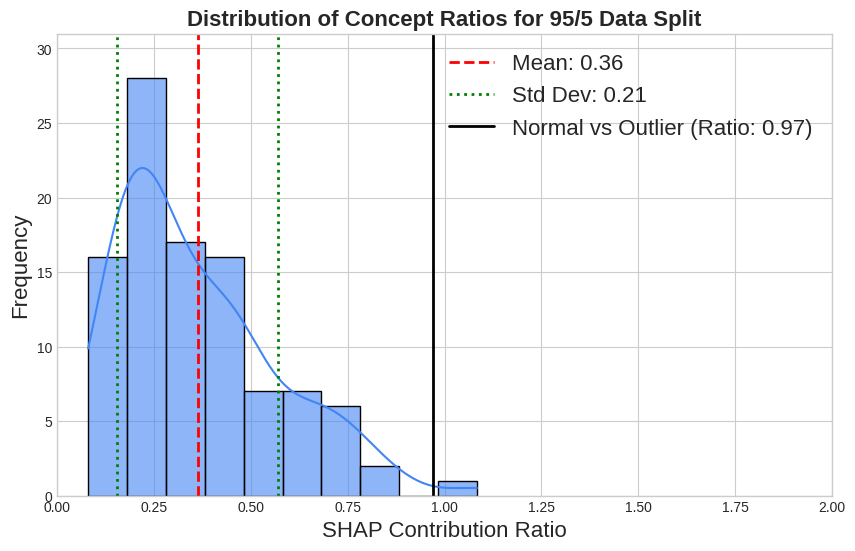

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Analyze Adjusted Data ---

# Define the adjusted files and their labels
files = ['/content/results_955_1.csv', '/content/results_955_2.csv', '/content/results_955_3.csv', '/content/results_955_4.csv', '/content/results_955_5.csv']

# Merge the files
df = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

print(df.head())

# Create a histogram for df
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='ConceptRatio', kde=True, color='#4285F4', alpha=0.6, binwidth=0.10)
plt.title('Distribution of Concept Ratios for 95/5 Data Split', fontsize=16, fontweight='bold')
plt.xlabel('SHAP Contribution Ratio', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xlim(0, 2)
plt.ylim(0, 31)

mean_val = df['ConceptRatio'].mean()
std_val = df['ConceptRatio'].std()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(mean_val + std_val, color='green', linestyle=':', linewidth=2, label=f'Std Dev: {std_val:.2f}')
plt.axvline(mean_val - std_val, color='green', linestyle=':', linewidth=2)

# add a solid vertical line at 0.97 and label this Normal vs Outlier
plt.axvline(0.97, color='black', linestyle='-', linewidth=2, label='Normal vs Outlier (Ratio: 0.97)')
plt.legend(fontsize=16)

plt.savefig('concept_ratio_955.png', dpi=300)
plt.show()

   Experiment#    GroupR  IndividualR  Concept1  Concept2  ConceptRatio
0            1  0.903662     0.748693  0.072291  0.062070      0.858621
1            2  0.888996     0.731650  0.050642  0.082088      1.620945
2            3  0.897007     0.733415  0.146724  0.126059      0.859161
3            4  0.822126     0.689888  0.131269  0.045441      0.346165
4            5  0.896295     0.746293  0.101526  0.053636      0.528301


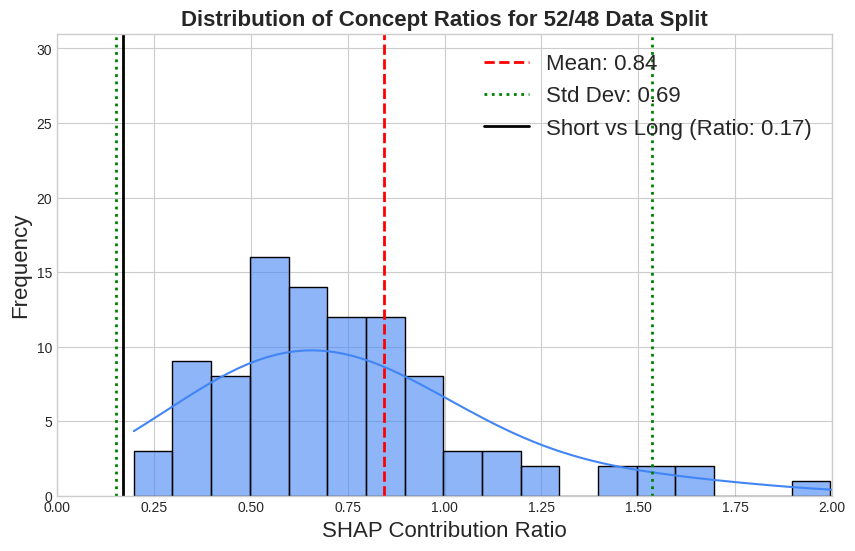

In [ ]:
# --- 1. Load and Analyze Adjusted Data ---

# Define the adjusted files and their labels
files = ['/content/results_5248_1.csv', '/content/results_5248_2.csv', '/content/results_5248_3.csv', '/content/results_5248_4.csv', '/content/results_5248_5.csv']

# Merge the files
df = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

print(df.head())

# Create a histogram for df
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='ConceptRatio', kde=True, color='#4285F4', alpha=0.6, binwidth=0.10)
plt.title('Distribution of Concept Ratios for 52/48 Data Split', fontsize=16, fontweight='bold')
plt.xlabel('SHAP Contribution Ratio', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xlim(0, 2)
plt.ylim(0, 31)

mean_val = df['ConceptRatio'].mean()
std_val = df['ConceptRatio'].std()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(mean_val + std_val, color='green', linestyle=':', linewidth=2, label=f'Std Dev: {std_val:.2f}')
plt.axvline(mean_val - std_val, color='green', linestyle=':', linewidth=2)

# add a solid vertical line at 0.97 and label this Normal vs Outlier
plt.axvline(0.17, color='black', linestyle='-', linewidth=2, label='Short vs Long (Ratio: 0.17)')
plt.legend(fontsize=16)

plt.savefig('concept_ratio_5248.png', dpi=300)
plt.show()

   Experiment#    GroupR  IndividualR  Concept1  Concept2  ConceptRatio
0            1  0.817741     0.692051  0.062743  0.031366      0.499920
1            2  0.885446     0.742392  0.109755  0.038726      0.352840
2            3  0.843630     0.715832  0.121206  0.026660      0.219953
3            4  0.830640     0.693100  0.075272  0.086686      1.151629
4            5  0.911863     0.753607  0.129050  0.068257      0.528915


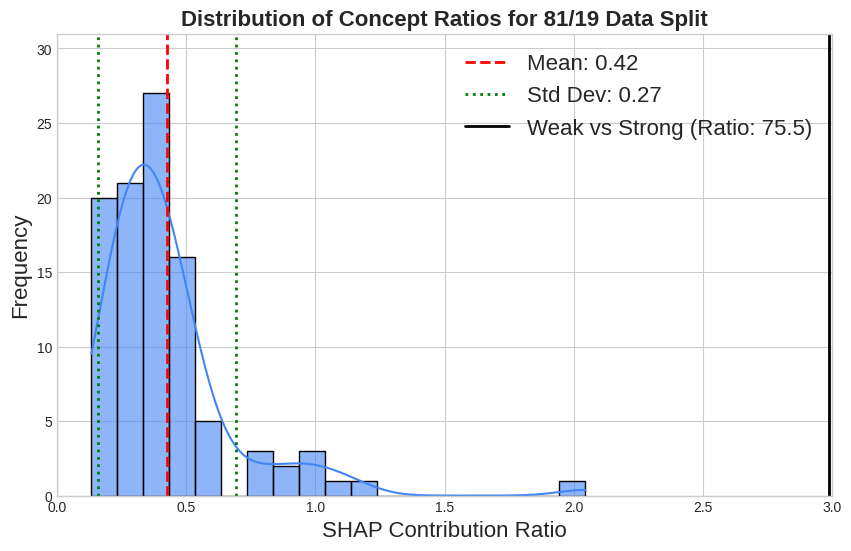

In [ ]:
# --- 1. Load and Analyze Adjusted Data ---

# Define the adjusted files and their labels
files = ['/content/results_8119_1.csv', '/content/results_8119_2.csv', '/content/results_8119_3.csv', '/content/results_8119_4.csv', '/content/results_8119_5.csv']

# Merge the files
df = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

print(df.head())

# Create a histogram for df
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='ConceptRatio', kde=True, color='#4285F4', alpha=0.6, binwidth=0.10)
plt.title('Distribution of Concept Ratios for 81/19 Data Split', fontsize=16, fontweight='bold')
plt.xlabel('SHAP Contribution Ratio', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xlim(0, 3)
plt.ylim(0, 31)

mean_val = df['ConceptRatio'].mean()
std_val = df['ConceptRatio'].std()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(mean_val + std_val, color='green', linestyle=':', linewidth=2, label=f'Std Dev: {std_val:.2f}')
plt.axvline(mean_val - std_val, color='green', linestyle=':', linewidth=2)

# add a solid vertical line at 0.97 and label this Normal vs Outlier
plt.axvline(2.99, color='black', linestyle='-', linewidth=2, label='Weak vs Strong (Ratio: 75.5)')
plt.legend(fontsize=16)

plt.savefig('concept_ratio_8119.png', dpi=300)
plt.show()